<a href="https://colab.research.google.com/github/google/brax/blob/main/notebooks/basics.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab">

# Brax: a differentiable physics engine

[Brax](https://github.com/google/brax) simulates physical systems made up of rigid bodies, joints, and actutators.  Brax provides the function:

$$
\text{qp}_{t+1} = \text{step}(\text{system}, \text{qp}_t, \text{act})
$$

where:
* $\text{system}$ is the static description of the physical system: each body in the world, its weight and size, and so on
* $\text{qp}_t$ is the dynamic state of the system at time $t$: each body's position, rotation, velocity, and angular velocity
* $\text{act}$ is dynamic input to the system in the form of motor actuation

Brax simulations are differentiable: the gradient $\Delta \text{step}$ can be used for efficient trajectory optimization.  But Brax is also well-suited to derivative-free optimization methods such as evolutionary strategy or reinforcement learning.

Let's review how $\text{system}$, $\text{qp}_t$, and $\text{act}$ are used:

In [ ]:
#@title Install Brax and some helper modules

from IPython.display import clear_output 

brax_url = "https://github.com/google/brax.git@main"
!pip install git+$brax_url
clear_output()

import brax
import jax
import jax.numpy as jnp
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

## Brax Config

Here's a brax config that defines a bouncy ball:

In [ ]:
#@title A bouncy ball scene
bouncy_ball = brax.Config(dt=0.05, substeps=100)

# ground is a frozen (immovable) infinite plane
ground = bouncy_ball.bodies.add(name='ground')
ground.frozen.all = True
plane = ground.colliders.add().plane
plane.SetInParent()  # for setting an empty oneof

# ball weighs 1kg, has equal rotational inertia along all axes, is 1m long, and
# has an initial rotation of identity (w=1,x=0,y=0,z=0) quaternion
ball = bouncy_ball.bodies.add(name='ball', mass=1)
ball.inertia.x, ball.inertia.y, ball.inertia.z = 1, 1, 1
cap = ball.colliders.add().capsule
cap.radius, cap.length = 0.5, 1

# gravity is -9.8 m/s^2 in z dimension
bouncy_ball.gravity.z = -9.8

We visualize this system config like so:

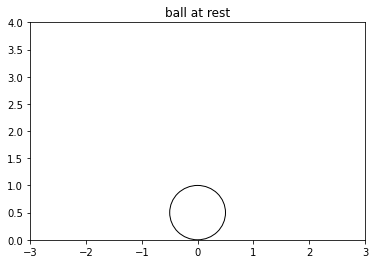

In [ ]:
def draw_system(ax, pos, alpha=1):
  for i, p in enumerate(pos):
    ax.add_patch(Circle(xy=(p[0], p[2]), radius=cap.radius, fill=False, color=(0, 0, 0, alpha)))
    if i < len(pos) - 1:
      pn = pos[i + 1]
      ax.add_line(Line2D([p[0], pn[0]], [p[2], pn[2]], color=(1, 0, 0, alpha)))

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

draw_system(ax, [[0, 0, 0.5]])
plt.title('ball at rest')
plt.show()

## Brax State

$\text{QP}$, brax's dynamic state, is a structure with the following fields:

In [ ]:
qp = brax.QP(
    # position of each body in 3d (z is up, right-hand coordinates)
    pos = jnp.array([[0., 0., 0.],       # ground
                    [0., 0., 3.]]),      # ball is 3m up in the air
    # velocity of each body in 3d
    vel = jnp.array([[0., 0., 0.],       # ground
                    [0., 0., 0.]]),      # ball
    # rotation about center of body, as a quaternion (w, x, y, z)
    rot = jnp.array([[1., 0., 0., 0.],   # ground
                    [1., 0., 0., 0.]]),  # ball
    # angular velocity about center of body in 3d
    ang = jnp.array([[0., 0., 0.],       # ground
                    [0., 0., 0.]])       # ball
)

## Brax Step Function

Let's observe $\text{step}(\text{config}, \text{qp}_t)$ with a few different variants of $\text{config}$ and $\text{qp}$:

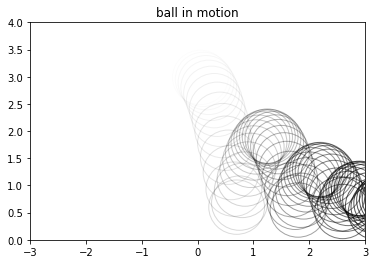

In [ ]:
#@title Simulating the bouncy ball config { run: "auto"}
bouncy_ball.elasticity = 0.75 #@param { type:"slider", min: 0, max: 0.95, step:0.05 }
ball_velocity = 1 #@param { type:"slider", min:-5, max:5, step: 0.5 }

sys = brax.System(bouncy_ball)

# provide an initial velocity to the ball
vel = jax.ops.index_update(qp.vel, jax.ops.index[1, 0], ball_velocity)
qp = qp.replace(vel=vel)

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(100):
  draw_system(ax, qp.pos[1:], i / 100.)
  qp, _ = sys.step(qp, [])

plt.title('ball in motion')
plt.show()

# Joints

Joints constrain the motion of bodies so that they move in tandem:

In [ ]:
#@title A pendulum config for Brax
pendulum = brax.Config(dt=0.01, substeps=100)

# start with a frozen anchor at the root of the pendulum
anchor = pendulum.bodies.add(name='anchor', mass=1.0)
anchor.frozen.all = True
anchor.inertia.x, anchor.inertia.y, anchor.inertia.z = 1, 1, 1

# now add a middle and bottom ball to the pendulum
pendulum.bodies.append(ball)
pendulum.bodies.append(ball)
pendulum.bodies[1].name = 'middle'
pendulum.bodies[2].name = 'bottom'

# connect anchor to middle
joint = pendulum.joints.add(name='joint1', parent='anchor',
                            child='middle', stiffness=10000, angular_damping=20)
joint.angle_limit.add(min = -180, max = 180)
joint.child_offset.z = 1.5
joint.rotation.z = 90

# connect middle to bottom
pendulum.joints.append(joint)
pendulum.joints[1].name = 'joint2'
pendulum.joints[1].parent = 'middle'
pendulum.joints[1].child = 'bottom'

# gravity is -9.8 m/s^2 in z dimension
pendulum.gravity.z = -9.8

# ignore collisions
pendulum.collide_include.add()

Here is our system at rest:

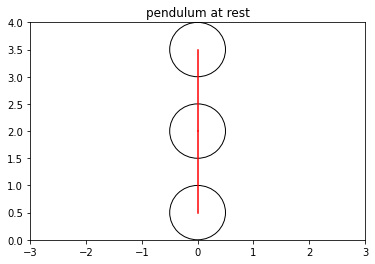

In [ ]:
_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

# rather than building our own qp like last time, we ask brax.System to
# generate a default one for us, which is handy
qp = brax.System(pendulum).default_qp()

draw_system(ax, qp.pos)
plt.title('pendulum at rest')
plt.show()

Let's observe $\text{step}(\text{config}, \text{qp}_t)$ by smacking the bottom ball with an initial impulse, simulating a pendulum swing.

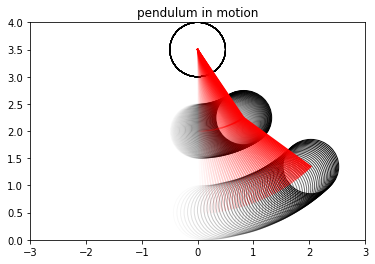

In [ ]:
#@title Simulating the pendulum config { run: "auto"}
ball_impulse = 8 #@param { type:"slider", min:-15, max:15, step: 0.5 }

sys = brax.System(pendulum)
qp = sys.default_qp()

# provide an initial velocity to the ball
vel = jax.ops.index_update(qp.vel, jax.ops.index[2, 0], ball_impulse)
qp = qp.replace(vel=vel)

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(50):
  draw_system(ax, qp.pos, i / 50.)
  qp, _ = sys.step(qp, [])

plt.title('pendulum in motion')
plt.show()

# Actuators

Actuators provide dynamic input to the system during every physics step.  They provide control parameters for users to manipulate the system interactively via the $\text{act}$ parameter.

In [ ]:
#@title A single actuator on the pendulum
actuated_pendulum = brax.Config()
actuated_pendulum.CopyFrom(pendulum)

# actuating the joint connecting the anchor and middle
angle = actuated_pendulum.actuators.add(name='actuator', joint='joint1',
                                        strength=100).angle
angle.SetInParent()  # for setting an empty oneof

Let's observe $\text{step}(\text{config}, \text{qp}_t, \text{act})$ by raising the middle ball to a desired target angle:

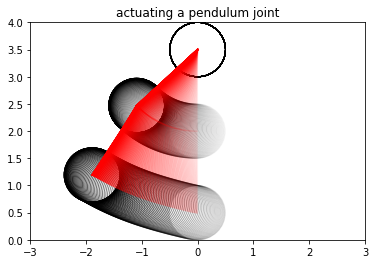

In [ ]:
#@title Simulating the actuated pendulum config { run: "auto"}
target_angle = 45 #@param { type:"slider", min:-90, max:90, step: 1 }

sys = brax.System(actuated_pendulum)
qp = sys.default_qp()
act = jnp.array([target_angle])

_, ax = plt.subplots()
plt.xlim([-3, 3])
plt.ylim([0, 4])

for i in range(100):
  draw_system(ax, qp.pos, i / 100.)
  qp, _ = sys.step(qp, act)

plt.title('actuating a pendulum joint')
plt.show()